In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
from random import sample

plt.rcParams["figure.figsize"] = (15,10)

## Генерация текста с помощью RNN

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('../../data/raw/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

In [4]:
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

In [5]:
len(names)

9384

In [6]:
max(map(len, names))

21

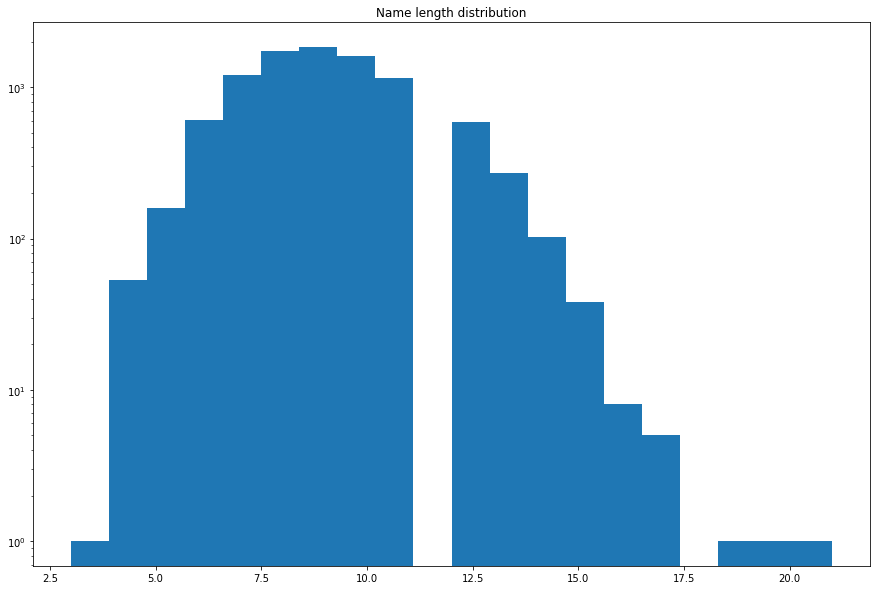

In [7]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=20);
plt.yscale("log")

## Препроцессинг

In [8]:
#all unique characters go here
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print ('num_tokens:', num_tokens)

num_tokens: 51


In [9]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [10]:
token_to_id[' ']

17

In [11]:
# Создание матрицы из пробельных элементов
np.zeros([5, 10], 'int32') + token_to_id[' ']

array([[17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17]], dtype=int32)

In [12]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [13]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[char] for char in data[i]]
        data_ix[i, :len(line_ix[:max_len])] = line_ix[:max_len]
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [14]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Utropov
[[17 39 24 25 24 23 15 17 17 17]
 [17  1 19 12 19 25 41 19  9 31]
 [17 20  0 25 12 23 15 31 17 17]
 [17  8 25 23 19 25  2 23 12 40]
 [17 13  4 32 15 36 15 31 17 17]]


In [15]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [23]:
char_rnn = CharRNNCell(num_tokens, 16, 64)

In [43]:
sum(t.numel() for t in char_rnn.parameters())

9315

In [25]:
batch = to_matrix(names[::2000], token_to_id)
batch

array([[12, 38, 40, 26, 40, 32, 11, 12, 12, 12],
       [12, 43,  3, 10,  3, 26, 24,  3, 15, 50],
       [12, 31, 33, 26, 10, 32, 11, 50, 12, 12],
       [12, 45, 26, 32,  3, 26, 44, 32, 10, 27],
       [12, 20, 13, 28, 11, 17, 11, 50, 12, 12]], dtype=int32)

In [28]:
inp = batch[: , 0]
inp

array([12, 12, 12, 12, 12], dtype=int32)

In [33]:
inp.shape

(5,)

In [30]:
x_emb = char_rnn.embedding(torch.LongTensor(inp))
x_emb

tensor([[ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768],
        [ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768],
        [ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768],
        [ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768],
        [ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768]],
       grad_fn=<EmbeddingBackward>)

In [35]:
h0 = char_rnn.initial_state(inp.size)
h0

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.

In [38]:
l1 = torch.cat([x_emb, h0], dim=1)
l1

tensor([[ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3901,  0.3248,  1.0714,  0.1552, -0.2723, -0.5799, -0.5407, -1.7678,
          1.0579,  0.6705,  0.1688,  1.3666, -0.2150,  0.8479,  0.8304, -0.3768,
          0.0000,  0.0000, 

In [40]:
l1.size()

torch.Size([5, 80])

In [44]:
h_next = char_rnn.rnn_update(l1)
h_next

tensor([[ 0.0776,  0.0523,  0.2613, -0.0008, -0.1856,  0.1299, -0.2940, -0.2944,
          0.0318,  0.0820, -0.2477,  0.2265,  0.0541,  0.0404,  0.0517, -0.4075,
          0.4332, -0.3924,  0.3622, -0.0440,  0.3989, -0.0227,  0.4254, -0.2303,
         -0.2139,  0.3318,  0.0992, -0.3486, -0.0106,  0.2222, -0.2136,  0.2970,
         -0.1860, -0.3328, -0.4963,  0.3921, -0.3033, -0.0415, -0.1516, -0.1799,
          0.2754, -0.0751,  0.1060, -0.4273,  0.1153, -0.0657,  0.0458,  0.1649,
          0.2454,  0.2234, -0.0257, -0.3205, -0.1437,  0.2978,  0.2131, -0.1713,
          0.0008,  0.0316, -0.2648,  0.1251,  0.3118, -0.2417,  0.1199, -0.1904],
        [ 0.0776,  0.0523,  0.2613, -0.0008, -0.1856,  0.1299, -0.2940, -0.2944,
          0.0318,  0.0820, -0.2477,  0.2265,  0.0541,  0.0404,  0.0517, -0.4075,
          0.4332, -0.3924,  0.3622, -0.0440,  0.3989, -0.0227,  0.4254, -0.2303,
         -0.2139,  0.3318,  0.0992, -0.3486, -0.0106,  0.2222, -0.2136,  0.2970,
         -0.1860, -0.3328, 

In [45]:
h_next = F.tanh(h_next)
h_next

tensor([[ 0.0775,  0.0522,  0.2555, -0.0008, -0.1835,  0.1292, -0.2858, -0.2862,
          0.0318,  0.0818, -0.2427,  0.2227,  0.0540,  0.0403,  0.0517, -0.3864,
          0.4080, -0.3734,  0.3471, -0.0440,  0.3790, -0.0227,  0.4015, -0.2263,
         -0.2107,  0.3201,  0.0989, -0.3351, -0.0106,  0.2186, -0.2104,  0.2886,
         -0.1839, -0.3211, -0.4592,  0.3732, -0.2943, -0.0414, -0.1505, -0.1780,
          0.2687, -0.0749,  0.1056, -0.4031,  0.1148, -0.0656,  0.0457,  0.1635,
          0.2406,  0.2197, -0.0257, -0.3100, -0.1427,  0.2893,  0.2099, -0.1696,
          0.0008,  0.0316, -0.2588,  0.1245,  0.3021, -0.2371,  0.1193, -0.1881],
        [ 0.0775,  0.0522,  0.2555, -0.0008, -0.1835,  0.1292, -0.2858, -0.2862,
          0.0318,  0.0818, -0.2427,  0.2227,  0.0540,  0.0403,  0.0517, -0.3864,
          0.4080, -0.3734,  0.3471, -0.0440,  0.3790, -0.0227,  0.4015, -0.2263,
         -0.2107,  0.3201,  0.0989, -0.3351, -0.0106,  0.2186, -0.2104,  0.2886,
         -0.1839, -0.3211, 

In [46]:
logits = char_rnn.rnn_to_logits(h_next)
logits

tensor([[-0.0048,  0.1866,  0.2054,  0.1296,  0.1129, -0.4171,  0.1326,  0.0375,
          0.3578,  0.0793,  0.0236, -0.0038,  0.1010,  0.0122, -0.0866, -0.0330,
          0.0072,  0.0787, -0.0778, -0.1932, -0.1322,  0.1510, -0.1436,  0.0562,
          0.1397,  0.1126, -0.0769,  0.1422,  0.0673, -0.2324,  0.0437,  0.0891,
         -0.1790, -0.0217,  0.0529, -0.2338,  0.2361, -0.2565,  0.1758,  0.2131,
         -0.0592, -0.1109, -0.3076,  0.0822,  0.1606, -0.2114,  0.3347, -0.0340,
          0.2252, -0.1721,  0.1129],
        [-0.0048,  0.1866,  0.2054,  0.1296,  0.1129, -0.4171,  0.1326,  0.0375,
          0.3578,  0.0793,  0.0236, -0.0038,  0.1010,  0.0122, -0.0866, -0.0330,
          0.0072,  0.0787, -0.0778, -0.1932, -0.1322,  0.1510, -0.1436,  0.0562,
          0.1397,  0.1126, -0.0769,  0.1422,  0.0673, -0.2324,  0.0437,  0.0891,
         -0.1790, -0.0217,  0.0529, -0.2338,  0.2361, -0.2565,  0.1758,  0.2131,
         -0.0592, -0.1109, -0.3076,  0.0822,  0.1606, -0.2114,  0.3347, 

In [60]:
result0 = F.log_softmax(logits, dim=-1)
result0

tensor([[-3.9668, -3.7754, -3.7566, -3.8323, -3.8491, -4.3791, -3.8293, -3.9245,
         -3.6042, -3.8827, -3.9384, -3.9658, -3.8610, -3.9498, -4.0486, -3.9950,
         -3.9548, -3.8833, -4.0398, -4.1551, -4.0941, -3.8110, -4.1056, -3.9058,
         -3.8222, -3.8493, -4.0388, -3.8198, -3.8947, -4.1944, -3.9183, -3.8729,
         -4.1410, -3.9837, -3.9091, -4.1958, -3.7259, -4.2185, -3.7861, -3.7489,
         -4.0211, -4.0729, -4.2696, -3.8798, -3.8014, -4.1734, -3.6273, -3.9960,
         -3.7367, -4.1341, -3.8491],
        [-3.9668, -3.7754, -3.7566, -3.8323, -3.8491, -4.3791, -3.8293, -3.9245,
         -3.6042, -3.8827, -3.9384, -3.9658, -3.8610, -3.9498, -4.0486, -3.9950,
         -3.9548, -3.8833, -4.0398, -4.1551, -4.0941, -3.8110, -4.1056, -3.9058,
         -3.8222, -3.8493, -4.0388, -3.8198, -3.8947, -4.1944, -3.9183, -3.8729,
         -4.1410, -3.9837, -3.9091, -4.1958, -3.7259, -4.2185, -3.7861, -3.7489,
         -4.0211, -4.0729, -4.2696, -3.8798, -3.8014, -4.1734, -3.6273, 

In [55]:
type(result0)

torch.Tensor

In [58]:
result0.size()

torch.Size([5, 51])

In [70]:
char_rnn = CharRNNCell(num_tokens, 16, 64)
batch_ix = torch.tensor(to_matrix(names[::2000], token_to_id), dtype=torch.int64)
batch_size, max_length = batch_ix.size()
hid_state = char_rnn.initial_state(batch_size)
logprobs = []

for x_t in batch_ix.transpose(0,1):
    hid_state, logp_next = char_rnn(x_t, hid_state)  
    logprobs.append(logp_next)

In [71]:
logprobs

[tensor([[-3.8980, -3.9461, -3.8081, -4.1693, -3.8329, -4.0937, -4.0180, -3.8074,
          -3.7639, -3.8589, -4.1835, -3.9556, -3.7933, -4.0354, -3.8820, -4.0612,
          -3.9662, -4.1059, -3.9049, -4.0919, -3.6900, -3.8962, -3.7824, -3.9531,
          -3.9925, -4.0465, -3.8014, -3.9354, -4.0799, -3.9172, -3.8433, -3.9533,
          -3.9749, -3.9307, -3.8852, -4.0809, -3.8206, -3.9140, -3.9971, -3.9659,
          -3.9754, -4.0042, -3.9116, -3.7102, -3.8653, -3.7976, -3.9990, -4.1605,
          -3.8681, -3.9075, -4.0226],
         [-3.8980, -3.9461, -3.8081, -4.1693, -3.8329, -4.0937, -4.0180, -3.8074,
          -3.7639, -3.8589, -4.1835, -3.9556, -3.7933, -4.0354, -3.8820, -4.0612,
          -3.9662, -4.1059, -3.9049, -4.0919, -3.6900, -3.8962, -3.7824, -3.9531,
          -3.9925, -4.0465, -3.8014, -3.9354, -4.0799, -3.9172, -3.8433, -3.9533,
          -3.9749, -3.9307, -3.8852, -4.0809, -3.8206, -3.9140, -3.9971, -3.9659,
          -3.9754, -4.0042, -3.9116, -3.7102, -3.8653, -3.79

In [74]:
logp_seq = torch.stack(logprobs, dim=1)

In [75]:
logp_seq.size()

torch.Size([5, 10, 51])

In [76]:
def rnn_loop(rnn: nn.Module, batch_index: int) -> torch.Tensor:
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [77]:
char_rnn = CharRNNCell(num_tokens, 16, 64)
batch_ix = torch.tensor(to_matrix(names[::2000], token_to_id), dtype=torch.int64)
logp_seq = rnn_loop(char_rnn, batch_ix)

In [78]:
batch_ix.size(), logp_seq.size()

(torch.Size([5, 10]), torch.Size([5, 10, 51]))

In [91]:
predictions_logp = logp_seq[:, :-1]
predictions_logp.size()

torch.Size([5, 9, 51])

In [92]:
actual_next_tokens = batch_ix[:, 1:]
actual_next_tokens.size()

torch.Size([5, 9])

In [93]:
logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None])
logp_next

tensor([[[-4.0072],
         [-4.0946],
         [-4.0579],
         [-3.9928],
         [-3.9396],
         [-3.6662],
         [-3.9661],
         [-3.8958],
         [-3.9319]],

        [[-3.9762],
         [-3.7695],
         [-3.9163],
         [-4.0667],
         [-4.1251],
         [-3.9309],
         [-3.8895],
         [-3.7349],
         [-4.2551]],

        [[-3.8030],
         [-3.9704],
         [-4.0099],
         [-3.9246],
         [-3.6592],
         [-3.7803],
         [-4.0446],
         [-3.8256],
         [-4.0526]],

        [[-4.0144],
         [-4.1921],
         [-3.9622],
         [-4.1527],
         [-4.1473],
         [-3.9330],
         [-3.6048],
         [-3.7301],
         [-3.9448]],

        [[-3.8913],
         [-4.0487],
         [-3.6997],
         [-3.6459],
         [-3.6878],
         [-4.1115],
         [-4.2032],
         [-3.7273],
         [-4.0588]]], grad_fn=<GatherBackward>)

In [94]:
loss = -logp_next.mean()
loss

tensor(3.9343, grad_fn=<NegBackward>)

In [31]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

In [96]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [97]:
print('Количество параметров', sum(np.product(t.shape) for t in char_rnn.parameters()))

Количество параметров 9315


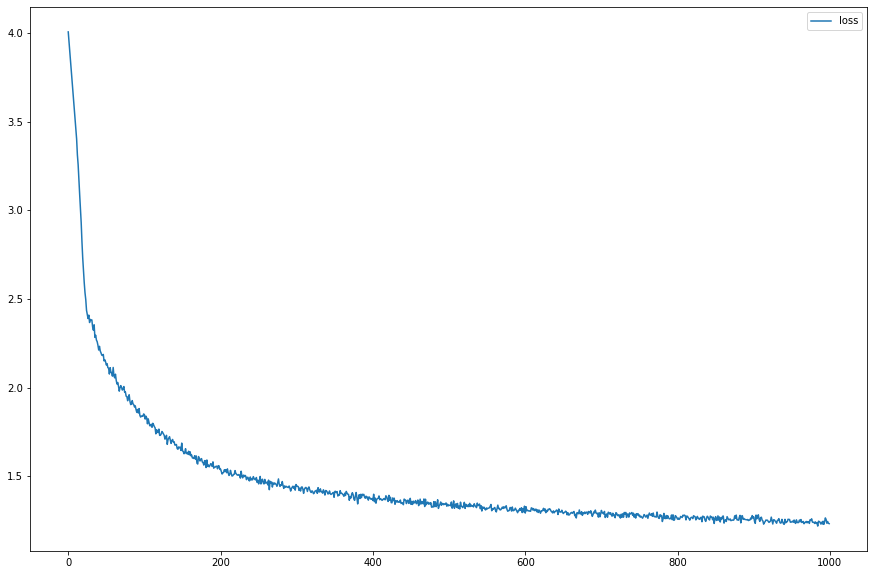

CPU times: user 25min 26s, sys: 1min 11s, total: 26min 38s
Wall time: 3min 12s


In [98]:
%%time

# MAX_LENGTH = max(map(len, names))
MAX_LENGTH = 15
BATCH_SIZE = 1024

for i in range(1000):
    batch_ix = to_matrix(sample(names, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [17]:
from torch.utils.data import DataLoader

In [18]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

In [37]:
def train_eval_loop(model, train_dataset, val_dataset,
                    criterion,
                    lr=1e-4,
                    epoch_n=10,
                    batch_size=32,
                    device=None,
                    early_stopping_patience=10,
                    l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Выбранное устройство: {device}")
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    history_mean_train_loss = []
    history_mean_val_loss = []  
    
    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
               
                pred = rnn_loop(model, batch_x)
#                 pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1
                
            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n, (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

#                     pred = model(batch_x)
                    pred = rnn_loop(model, batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format( early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            history_mean_train_loss.append(mean_train_loss)
            history_mean_val_loss.append(mean_val_loss)
    
            # visualizing training process
            if (epoch_i + 1) % 2 == 0:
                clear_output(True)
                plt.plot(history_mean_train_loss, label='train_loss')
                plt.plot(history_mean_val_loss, label='valid_loss')
                plt.legend()
                plt.show()
        
            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [20]:
from torch.utils.data import Dataset
import copy
import traceback
import datetime

In [129]:
class LanguageModelDataset(Dataset):
    def __init__(self, names, vocab, max_length=100, pad_value=0):
        self.names = names
        self.max_length = max_length
        self.pad_value = pad_value
        self.vocab = vocab
        
    def __len__(self):
        return len(self.names)

    def __getitem__(self, item):
        text = self.names[item]
        text_to_id = self.to_matrix(text)
        seed_part = torch.from_numpy(text_to_id[:self.max_length-1].astype("int64"))
        target_part = torch.from_numpy(text_to_id[1:].astype("int64"))
        return seed_part, target_part

    def to_matrix(self, data):
        """
        Casts a list of names into rnn-digestable matrix
        """
        data_ix = np.zeros(self.max_length, 'int32') + self.vocab[' ']
        line_ix = [self.vocab[char] for char in data]
        data_ix[:len(line_ix[:self.max_length])] = line_ix[:self.max_length]
        return data_ix

In [130]:
np.random.shuffle(names)

TRAIN_SPLIT = int(len(names) * 0.7)
train_texts = names[:TRAIN_SPLIT]
test_texts = names[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 6568
Размер валидационной выборки 2816


In [131]:
MAX_LENGTH = 15

train_dataset = LanguageModelDataset(
    train_texts, 
    token_to_id, 
    max_length=MAX_LENGTH, 
    pad_value=token_to_id[" "]
)
test_dataset = LanguageModelDataset(
    test_texts, 
    token_to_id, 
    max_length=MAX_LENGTH, 
    pad_value=token_to_id[" "]
)

In [132]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=1
)
val_dataloader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False,
    num_workers=1
)

In [133]:
for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
#     batch_i, (batch_x, batch_y)
    break

In [28]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [34]:
def rnn_loop(rnn: nn.Module, batch_index: int) -> torch.Tensor:
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [35]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

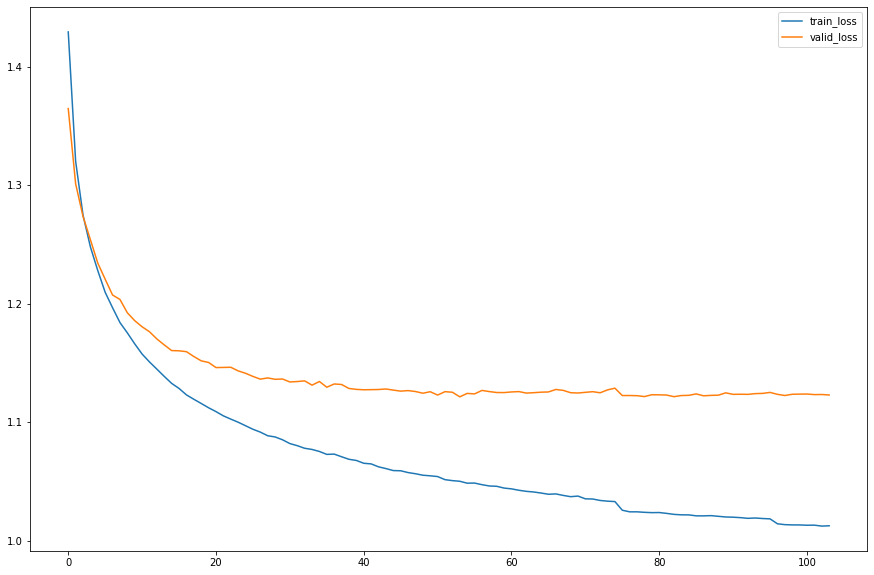


Эпоха 104
Эпоха: 103 итераций, 3.06 сек
Среднее значение функции потерь на обучении 1.0126099603847392
Среднее значение функции потерь на валидации 1.1230373192917218
Модель не улучшилась за последние 50 эпох, прекращаем обучение
CPU times: user 53min 21s, sys: 2min 4s, total: 55min 26s
Wall time: 5min 58s


In [38]:
%%time

best_val_loss, best_torch_transf_model = train_eval_loop(char_rnn, train_dataset, test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=5000,
    batch_size=64,
    device='cpu',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler
)

In [39]:
best_torch_transf_model

CharRNNCell(
  (embedding): Embedding(51, 16)
  (rnn_update): Linear(in_features=80, out_features=64, bias=True)
  (rnn_to_logits): Linear(in_features=64, out_features=51, bias=True)
)

In [40]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [41]:
for _ in range(10):
    print(generate_sample(best_torch_transf_model))

  Golovlazdev  
  Vyazilyankiev
  Abanov       
  Velyarnien   
  Yakovazavolko
  Bachakov     
  Lozfin       
  Abragubovich 
  Abanimtin    
  Meliman      


In [42]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Ar'))

 Arovenko      
 Arkin         
 Arovich       
 Arovlyanov    
 Arovlyakov    
 Arovich       
 Arkov         
 Arihin        
 Arov          
 Arykhin       


In [134]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [139]:
def train_eval_loop(model, train_dataset, val_dataset,
                    criterion,
                    lr=1e-4,
                    epoch_n=10,
                    batch_size=32,
                    device=None,
                    early_stopping_patience=10,
                    l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Выбранное устройство: {device}")
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    history_mean_train_loss = []
    history_mean_val_loss = []  
    
    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
            
                # pred = rnn_loop(model, batch_x)
                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1
                
            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n, (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
#                     pred = rnn_loop(model, batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format( early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            history_mean_train_loss.append(mean_train_loss)
            history_mean_val_loss.append(mean_val_loss)
    
            # visualizing training process
            if (epoch_i + 1) % 2 == 0:
                clear_output(True)
                plt.plot(history_mean_train_loss, label='train_loss')
                plt.plot(history_mean_val_loss, label='valid_loss')
                plt.legend()
                plt.show()
        
            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [140]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [141]:
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 9379


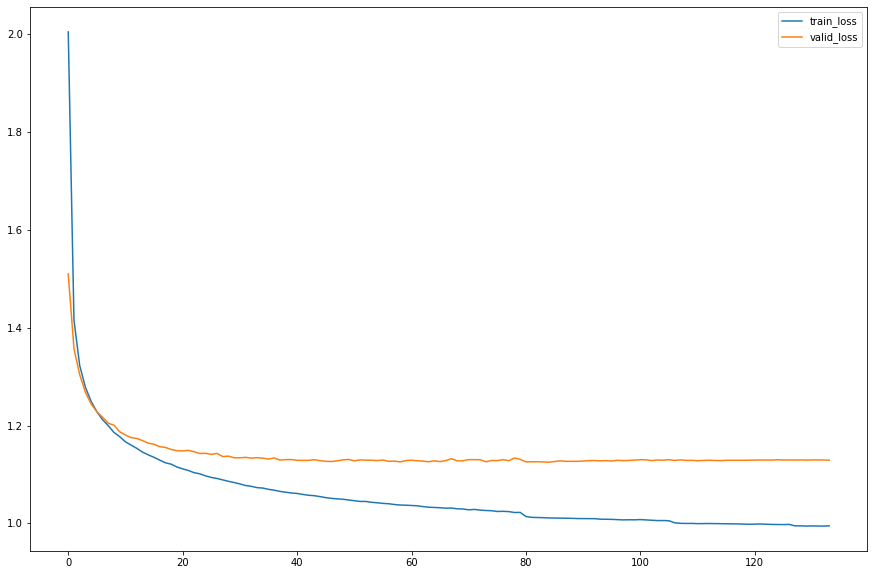


Эпоха 134
Эпоха: 103 итераций, 1.70 сек
Среднее значение функции потерь на обучении 0.994394686036897
Среднее значение функции потерь на валидации 1.1299108998341993

Эпоха 135
Эпоха: 103 итераций, 1.72 сек
Среднее значение функции потерь на обучении 0.9944440768760385
Среднее значение функции потерь на валидации 1.1297293495048175
Модель не улучшилась за последние 50 эпох, прекращаем обучение
CPU times: user 34min 49s, sys: 1min 12s, total: 36min 2s
Wall time: 4min 47s


In [142]:
%%time

best_val_loss, best_torch_transf_model = train_eval_loop(model, train_dataset, test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=5000,
    batch_size=64,
    device='cpu',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler
)

In [80]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

logp_seq = model(batch_ix)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

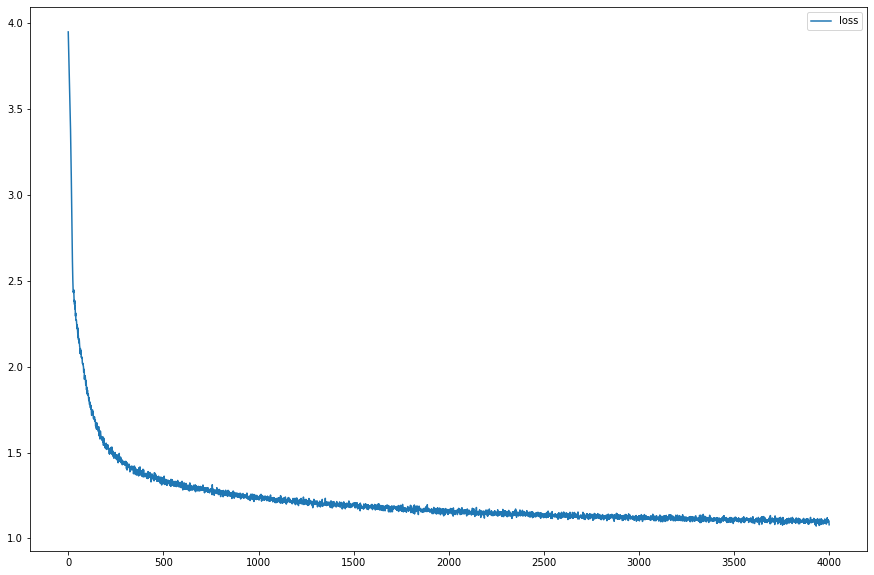

CPU times: user 1h 26min 33s, sys: 2min 59s, total: 1h 29min 32s
Wall time: 12min 21s


In [81]:
%%time

# MAX_LENGTH = max(map(len, names))
MAX_LENGTH = 15
BATCH_SIZE = 1024


for i in range(4000):
    batch_ix = to_matrix(sample(names, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [50]:
for _ in range(10):
    print(generate_sample(char_rnn))

AttributeError: 'CharRNNLoop' object has no attribute 'initial_state'

In [121]:
from simcube.pipeline import init_random_seed, copy_data_to_device

In [122]:
init_random_seed(42)

In [123]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
#         assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [124]:
MAX_LENGTH = 18
BATCH_SIZE = 1024

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [126]:
device = torch.device(device)

In [127]:
model = CharRNNLoop(emb_size=32)
opt = torch.optim.Adam(model.parameters())
history = []

In [128]:
model.to(device)

CharRNNLoop(
  (emb): Embedding(51, 32)
  (rnn): RNN(32, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=51, bias=True)
)

In [129]:
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 11219


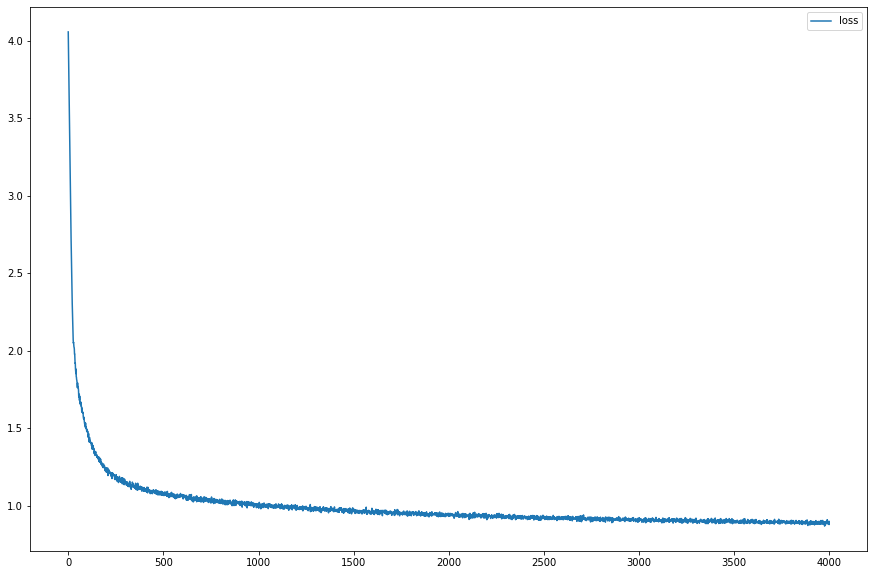

CPU times: user 43 s, sys: 415 ms, total: 43.5 s
Wall time: 43.1 s


In [130]:
%%time

for i in range(4000):
    batch_ix = to_matrix(sample(names, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = copy_data_to_device(batch_ix, device)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
        
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [63]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence, ], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [143]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence, ], dtype=torch.int64)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next = char_rnn(x_sequence,)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [148]:
for _ in range(10):
    print(generate_sample(best_torch_transf_model, seed_phrase="Trump"))

Trumphrzzzzzzzz
Trumpzzzlzzzzzc
Trumpdhnzzzzzzz
Trumpzzzzrzhzrz
Trumpzzrrzrizrz
Trumpzhzzzzzorz
Trumprzzzzzzzzz
Trumpzzrzhclzzz
Trumpzhzzihrzzr
Trumpnzzzlznzzz


In [146]:
for _ in range(10):
    print(generate_sample(best_torch_transf_model))

 VDHGZMZYBGLSAD
 YVYRDGTVLBZZOA
 YBTSYYODJVSPPO
 AVJMGGLTADMRMY
 HADVVHLTPGSPAB
 YYASAJPGYSDZNA
 JMJAZTZYBBMEHV
 GZZJYZJZJDJBBB
 GASGMBSVDRZVZB
 FHPESTRJAATBYC


In [ ]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.IntTensor(batch_ix))

logp_seq = model(batch_ix)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

In [32]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('../../data/raw/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

In [33]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [34]:
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)